In [62]:
# data wrangling and analysis
import pandas as pd 
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset

# visualization
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
import seaborn as sns
import mpl_toolkits
%matplotlib inline

#machine learning 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM

# other
import warnings
warnings.filterwarnings("ignore")
import datetime
import time
import math

In [2]:
pip install netCDF4

In [3]:
#data prepocessing
data_cuxhaven=pd.read_csv("C:\\Users\\20109\\Downloads\\cuxhaven_de.csv")
data_cuxhaven.head()

,time hours since 1900-01-01 00:00:00.0,u10 m s**-1,v10 m s**-1,msl Pa,Distance Weight,surge m
0,973008,9.304976,0.647637,101466.523656,1.000000,0.040876
1,973008,11.284721,0.234706,101549.947853,0.925527,0.040876
2,973008,9.304976,1.105641,101377.553920,0.668373,0.040876
3,973008,7.498699,1.067838,101748.381707,0.654728,0.040876
4,973008,7.834623,0.971875,101808.900417,0.624854,0.040876


In [4]:
#rename the columns
data_cuxhaven.columns=['time','wind_u10','wind_v10','slp','weight','surge']

In [5]:
data_cuxhaven.head()

,time,wind_u10,wind_v10,slp,weight,surge
0,973008,9.304976,0.647637,101466.523656,1.000000,0.040876
1,973008,11.284721,0.234706,101549.947853,0.925527,0.040876
2,973008,9.304976,1.105641,101377.553920,0.668373,0.040876
3,973008,7.498699,1.067838,101748.381707,0.654728,0.040876
4,973008,7.834623,0.971875,101808.900417,0.624854,0.040876


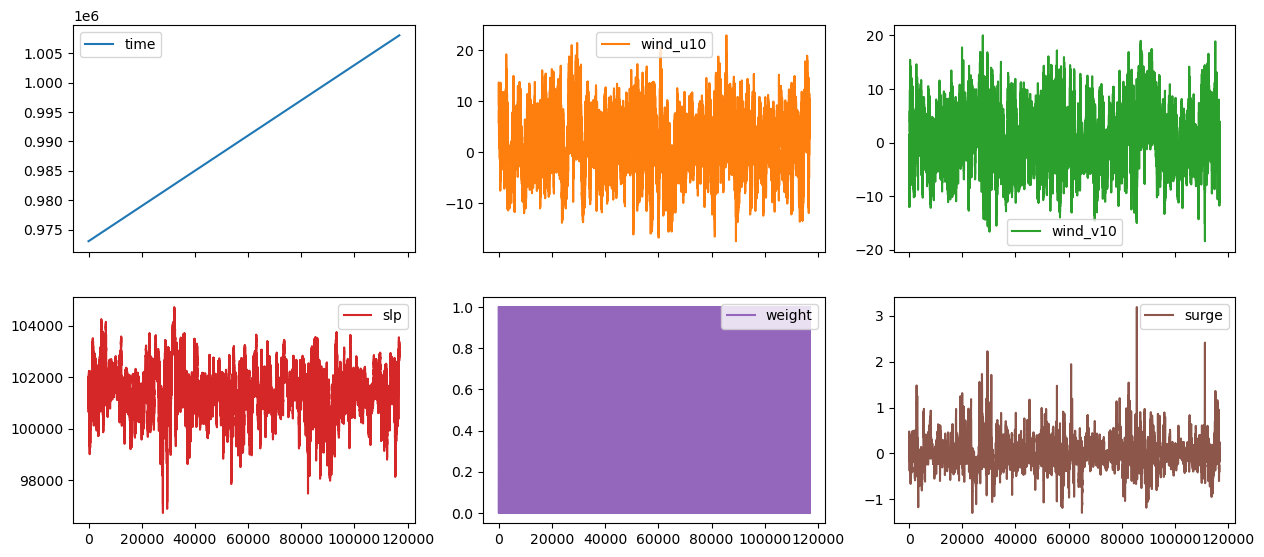

In [6]:
data_cuxhaven.plot(subplots=True, layout=(3,3),figsize=(15,10))
plt.show()

In [7]:
#check for missing values
data_cuxhaven.isna().sum()

time        0
wind_u10    0
wind_v10    0
slp         0
weight      0
surge       0
dtype: int64

In [29]:
# build a function for creating time lagged time series data
def time_lag(data, lags):
    """
    Transforms the dataset to  a time series of grid information and spits back the time lagged time series
    data - the full name of the csv file
    """
    time_orig = pd.to_datetime('1900-01-01')

    df = pd.read_csv(data)
    df.columns = ['time', 'wind_u10', 'wind_v10', 'slp', 'weight', 'surge'] 
    
    # reorganize the matrix
    df_new = df.loc[df['weight'] == df['weight'].unique()[0]]
    df_new.drop(['weight'], axis = 1, inplace=True) #, 'surge'
    
    for i in range(1,10):
        df_sub = df.loc[df['weight'] == df['weight'].unique()[i]]
        df_sub.drop(['weight', 'surge'], axis = 1, inplace=True)
        df_new = pd.merge(df_new, df_sub, on='time')
    
    
    # lag the time series data
    lagged_df = df_new.copy() # to prevent modifying original matrix
    for j in range(lags):
        #lagged.drop(j, axis = 0, inplace = True)
        lagged_df['time'] = lagged_df['time'] + 6
        
        # remove the last row since there is no match for it in df_new
        lagged_df.drop(lagged_df.tail(1).index.item(), axis = 0, inplace = True)
        
        # remove the topmost row from df_new to match lagged
        df_new.drop(df_new.head(1).index.item(), axis = 0, inplace = True)
        
        # merge lagged data with df_new
        df_new = pd.merge(df_new, lagged_df, on = 'time', how = 'outer', \
                       suffixes = ('_left', '_right'))
    df_new = df_new.T.reset_index(drop=True).T
    ind = df_new.loc[pd.isna(df_new[df_new.shape[1]-1]), :].index
    df_new.drop(ind, inplace=True)
    
    # storm surge time series data
    surge_ts = pd.DataFrame(df.loc[df['weight'] == \
                                df['weight'].unique()[0]][['time', 'surge']])
    # remove missing/NaN values
    surge_ts.reset_index(inplace=True) # reset index for subsetting isnans
    surge_ts.drop(['index'], axis = 1, inplace=True)    
    indx = surge_ts.loc[pd.isna(surge_ts["surge"]), :].index
    df_new.drop(indx, inplace=True)
    surge_ts.drop(indx, inplace=True)
    
    # filter surge according to df_new
    lagged_time = list(df_new[0])
    time_df_new = [float(x) for x in df_new[0]]
    time_surge_ts = [float(x) for x in surge_ts['time']]
    time_both = []
    for k in lagged_time:
        if ((k in time_df_new) & (k in time_surge_ts)):
            time_both.append(int(k))
            
    surge_ts = surge_ts[surge_ts['time'].isin(time_both)]
    
    dt = pd.DataFrame(columns = ['date']);
    for i in surge_ts.index:
        dt.loc[i, 'date'] = time_orig + \
            datetime.timedelta(hours = int(surge_ts.loc[i, 'time']))
            
    surge_ts['date'] = dt
    df_new = df_new[df_new[0].isin([x*1.0 for x in time_both])]
    df_new.drop(4, axis = 1, inplace = True) # remove the un-lagged surge data
    return df_new, surge_ts


In [30]:
data="C:\\Users\\20109\\Downloads\\cuxhaven_de.csv"
x,surge= time_lag(data,5)

In [31]:
print(x)

            0         1         2              3         5         6    \
0      973038.0  3.016050 -3.749202  101652.419770  4.164247 -6.533576   
1      973044.0  3.787021 -3.592172  101777.797176  4.953116 -5.853113   
2      973050.0  2.587885 -2.344656  101853.264729  3.237704 -4.876038   
3      973056.0  2.210660 -2.074216  101987.804329  2.875623 -4.002195   
4      973062.0  2.441951 -0.915393  102017.702018  3.123435 -2.213798   
...         ...       ...       ...            ...       ...       ...   
5834  1008042.0  3.226690  0.178001  102921.383778  4.326702 -0.628958   
5835  1008048.0  4.420320 -0.333800  102856.283971  5.977407 -1.312330   
5836  1008054.0  4.255111 -1.222183  102862.552842  5.304184 -1.989885   
5837  1008060.0  5.181654 -0.467566  103017.586826  6.640993 -0.053182   
5838  1008066.0  6.102690  1.496762  103088.232171  8.220109  2.276096   

                7         8         9              10   ...            177  \
0     101739.219512  2.696647 -2.

In [32]:
print(surge)

         time     surge                 date
5      973038 -0.173340  2011-01-02 06:00:00
6      973044  0.022045  2011-01-02 12:00:00
7      973050 -0.243710  2011-01-02 18:00:00
8      973056 -0.061471  2011-01-03 00:00:00
9      973062 -0.380670  2011-01-03 06:00:00
...       ...       ...                  ...
5839  1008042  0.098466  2014-12-30 18:00:00
5840  1008048  0.056440  2014-12-31 00:00:00
5841  1008054  0.243050  2014-12-31 06:00:00
5842  1008060  0.119040  2014-12-31 12:00:00
5843  1008066  0.189340  2014-12-31 18:00:00

[5839 rows x 3 columns]


In [33]:
#split data into train and test data
x_train,x_test,y_train,y_test=train_test_split(x,surge,shuffle=False,test_size=0.20,random_state=42)

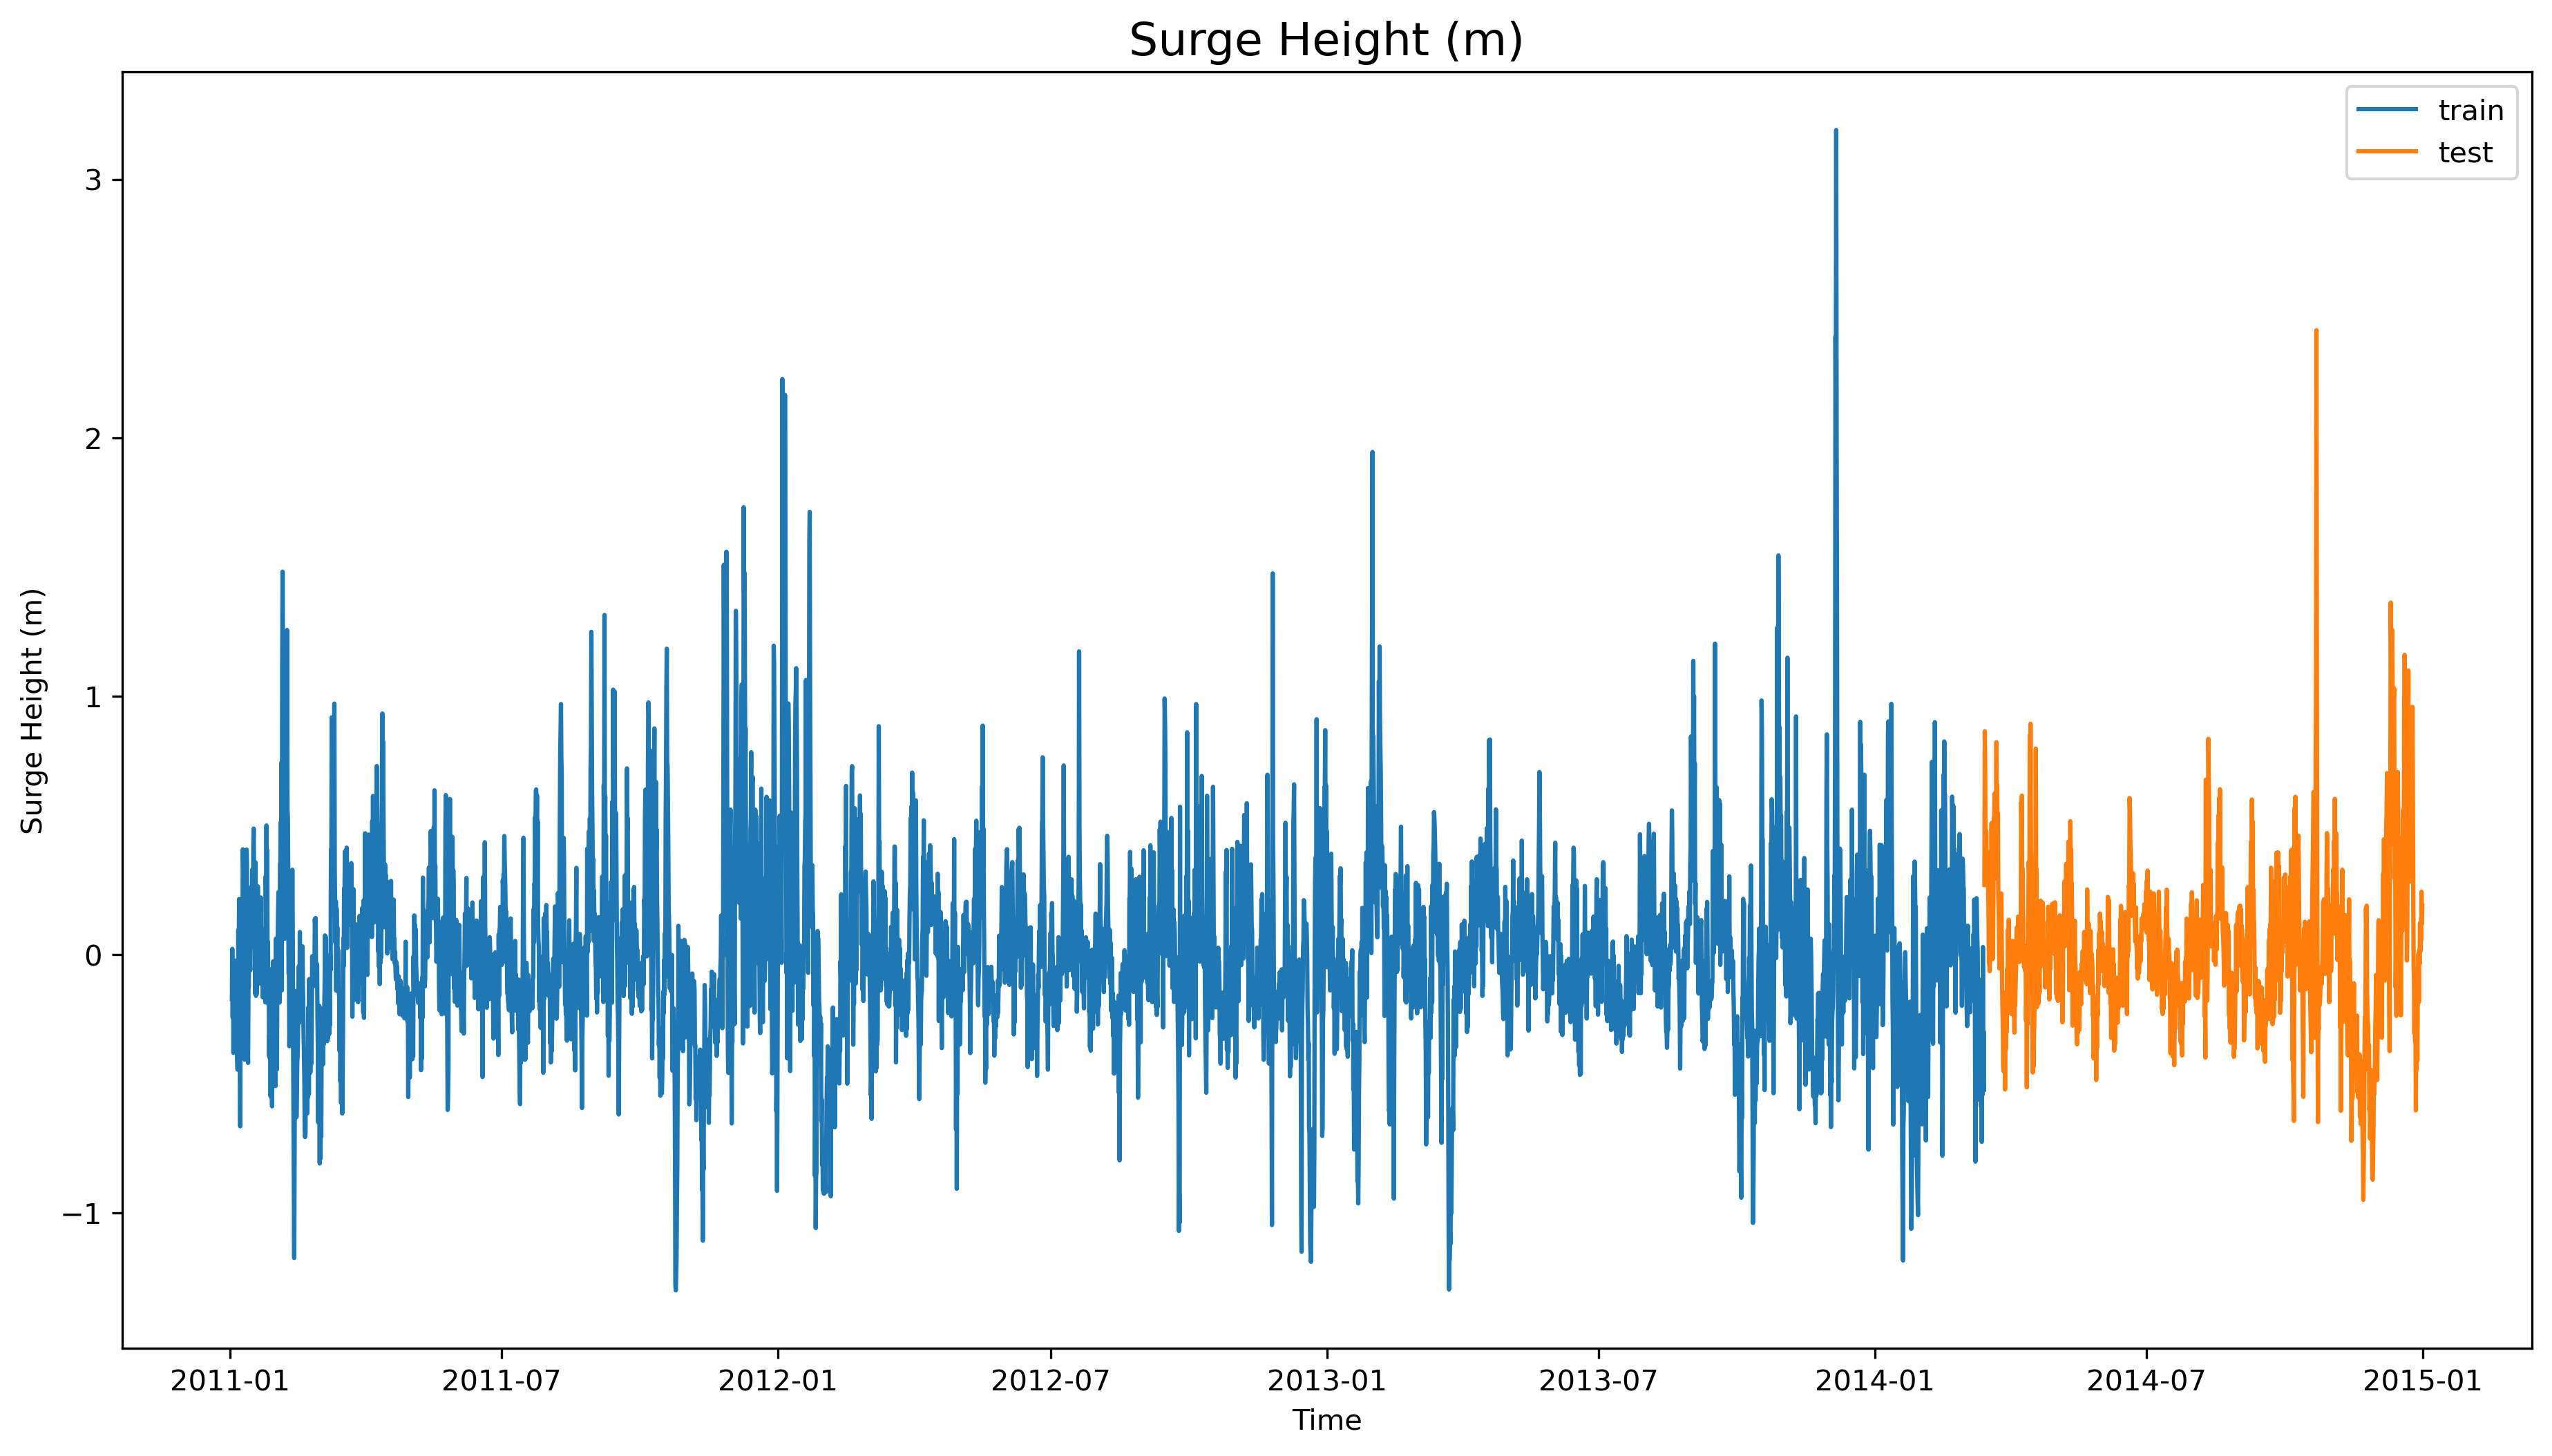

In [35]:
# Visualize the train and test values
fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
ax.plot(y_train['date'], y_train['surge'], label='train')
ax.plot(y_test['date'], y_test['surge'], label='test')
ax.set_title("Surge Height (m)", fontsize=16)
ax.set_xlabel('Time')
ax.set_ylabel('Surge Height (m)')
ax.legend(loc='best')
plt.show()

In [36]:
x_train.shape

(4671, 186)

In [37]:
x_test.shape

(1168, 186)

In [38]:
x.shape

(5839, 186)

In [39]:
surge.shape

(5839, 3)

In [41]:
y_train.shape

(4671, 3)

In [43]:
#standardizing the training and testing dataset
x_norm_train=preprocessing.scale(x_train)
x_norm_test=preprocessing.scale(x_test)

In [44]:
print(x_norm_train)

[[-1.73168004  0.42167951 -1.53336619 ...  1.64670587 -0.08773406
   0.39835794]
 [-1.73093842  0.61715977 -1.48225843 ...  1.39552918 -1.16409738
   0.0812966 ]
 [-1.7301968   0.31311816 -1.07623574 ...  0.98069269 -1.68641603
   0.21079009]
 ...
 [ 1.7301968  -0.1207782  -0.75491941 ... -0.90771374  0.1645265
   1.61717828]
 [ 1.73093842  0.42342487  0.27244105 ... -0.47170891 -0.10591849
   1.4441908 ]
 [ 1.73168004  1.32193591  0.91412727 ...  0.02085017 -0.50133305
   1.43183456]]


In [45]:
print(y_test)

         time     surge                 date
4676  1001064  0.269050  2014-03-15 00:00:00
4677  1001070  0.863970  2014-03-15 06:00:00
4678  1001076  0.715220  2014-03-15 12:00:00
4679  1001082  0.411040  2014-03-15 18:00:00
4680  1001088  0.337190  2014-03-16 00:00:00
...       ...       ...                  ...
5839  1008042  0.098466  2014-12-30 18:00:00
5840  1008048  0.056440  2014-12-31 00:00:00
5841  1008054  0.243050  2014-12-31 06:00:00
5842  1008060  0.119040  2014-12-31 12:00:00
5843  1008066  0.189340  2014-12-31 18:00:00

[1168 rows x 3 columns]


In [46]:
print(y_train)

         time     surge                 date
5      973038 -0.173340  2011-01-02 06:00:00
6      973044  0.022045  2011-01-02 12:00:00
7      973050 -0.243710  2011-01-02 18:00:00
8      973056 -0.061471  2011-01-03 00:00:00
9      973062 -0.380670  2011-01-03 06:00:00
...       ...       ...                  ...
4671  1001034 -0.542870  2014-03-13 18:00:00
4672  1001040  0.029064  2014-03-14 00:00:00
4673  1001046 -0.525450  2014-03-14 06:00:00
4674  1001052 -0.297770  2014-03-14 12:00:00
4675  1001058 -0.522620  2014-03-14 18:00:00

[4671 rows x 3 columns]


In [47]:
# create a function for plotting autocorrelations 

def autcorrplt(data, lag, title, *args):
    """
    plots the autocorrelation of a pandas series object
    """
    acorr = [];
    for i in range(lag+1):
        acorr.append(data.autocorr(lag = i))
    
    plt.figure(figsize = (8, 6))
    plt.plot(acorr)
    plt.xlabel("Lag (in 6 hrs)", fontsize = 12)
    plt.ylabel("Correlation", fontsize = 12)
    plt.ylim([0, 1])
    plt.xlim([1, lag])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title(f"Autocorrelation in {title}", fontsize = 16, y=1.03)
    plt.savefig(f"Autocorrelation in {title}.png", dpi=300)

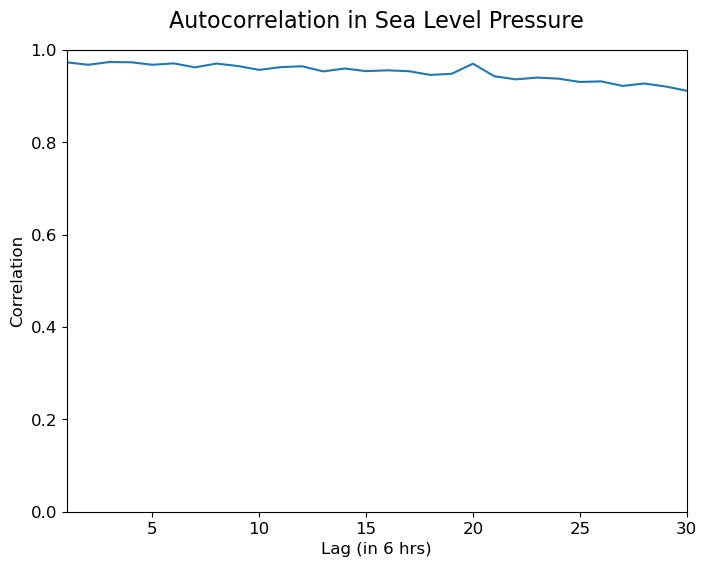

In [48]:
autcorrplt(data_cuxhaven['slp'], 30, "Sea Level Pressure")

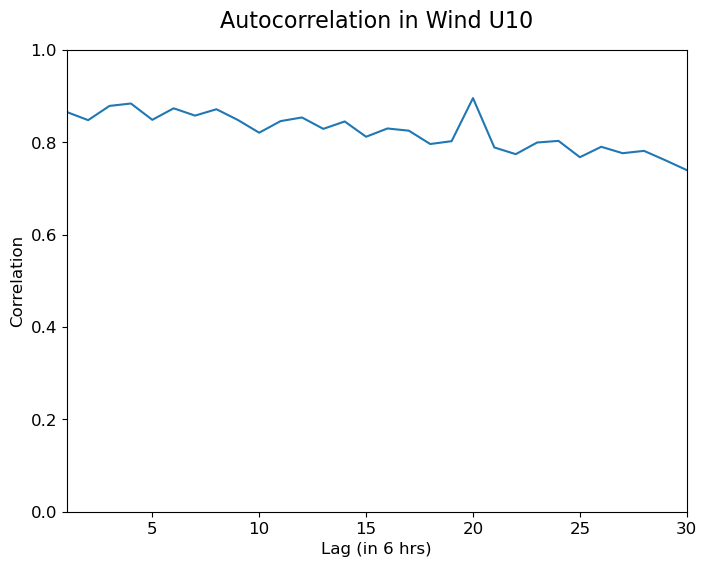

In [49]:
autcorrplt(data_cuxhaven['wind_u10'], 30, "Wind U10")

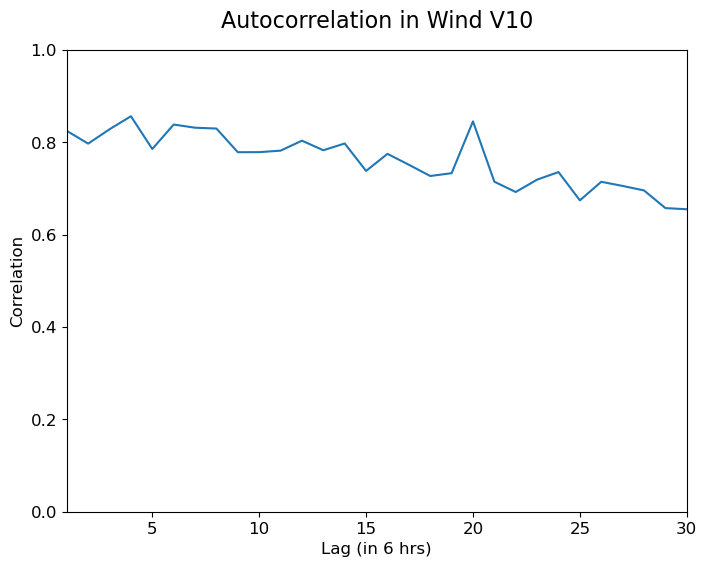

In [50]:
autcorrplt(data_cuxhaven['wind_v10'], 30, "Wind V10")

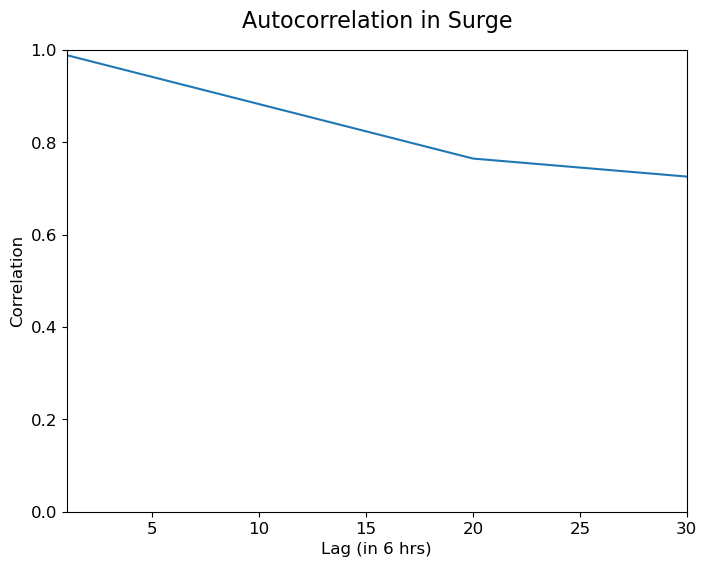

In [51]:
autcorrplt(data_cuxhaven['surge'], 30, "Surge")

In [69]:
# build a function for implementing MLP Sequential Model 

def mlp_seq(x_norm_train, x_norm_test, y_train, y_test):
    """
    Builds mlp, trains and tests it
    """
    # simple model
    model = Sequential()
    model.add(Dropout(0.2, input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation = 'sigmoid',\
                    input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation='sigmoid'))
    model.add(BatchNormalization())
    # model.add(Dense(180, activation='relu'))
    model.add(Dense(1))
    
    # training model
    model.compile(loss = 'mean_squared_error', optimizer = 'adagrad', \
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    history = model.fit(x_norm_train, y_train['surge'], epochs = 100,
              batch_size = 10, verbose = 1, validation_split=0.20)
    
    testPredict = model.predict(x_norm_test)
    
    # prepare the data for plotting
    y = y_test[:]
    y.reset_index(inplace=True)
    y.drop(['index'], axis = 1, inplace=True) 
    
    # model evaluation
    print()
    print("mse = ", mean_squared_error(y_test['surge'], testPredict))
    print("mae = ", mean_absolute_error(y_test['surge'], testPredict))
    print("r2_score = ", r2_score(y_test['surge'], testPredict))

    print()
    
    # plotting 
    sns.set_context('notebook', font_scale= 1.5)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test['date'], y['surge'], color = 'blue')
    plt.plot(y_test['date'],testPredict, color= 'red')
    plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel('Surge Height (m)')
    plt.title("Observed vs. Predicted Storm Surge Height", fontsize=20, y=1.03)
    plt.savefig("1 mlp observed vs predicted surge height.png", dpi=300)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test['surge'], testPredict, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.show()

    # list all the data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('MLP Model Accuracy', fontsize=18, y=1.03)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig("2 mlp model accuracy.png", dpi=300)
    plt.show()

    # summarize history for loss
    plt.figure(figsize = (12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MLP Model Loss', fontsize=18, y=1.03)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig("3 mlp model loss.png", dpi=300)
    plt.show()
    return testPredict

Epoch 1/100
374/374 [==============================] - 3s 5ms/step - loss: 0.2521 - mean_squared_error: 0.2521 - mean_absolute_error: 0.3845 - val_loss: 0.0936 - val_mean_squared_error: 0.0936 - val_mean_absolute_error: 0.2088
Epoch 2/100
374/374 [==============================] - 2s 5ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - mean_absolute_error: 0.2862 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1742
Epoch 3/100
374/374 [==============================] - 1s 4ms/step - loss: 0.1153 - mean_squared_error: 0.1153 - mean_absolute_error: 0.2635 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.1882
Epoch 4/100
374/374 [==============================] - 1s 2ms/step - loss: 0.0990 - mean_squared_error: 0.0990 - mean_absolute_error: 0.2427 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1740
Epoch 5/100
374/374 [==============================] - 1s 3ms/step - loss: 0.0904 - mean_squ

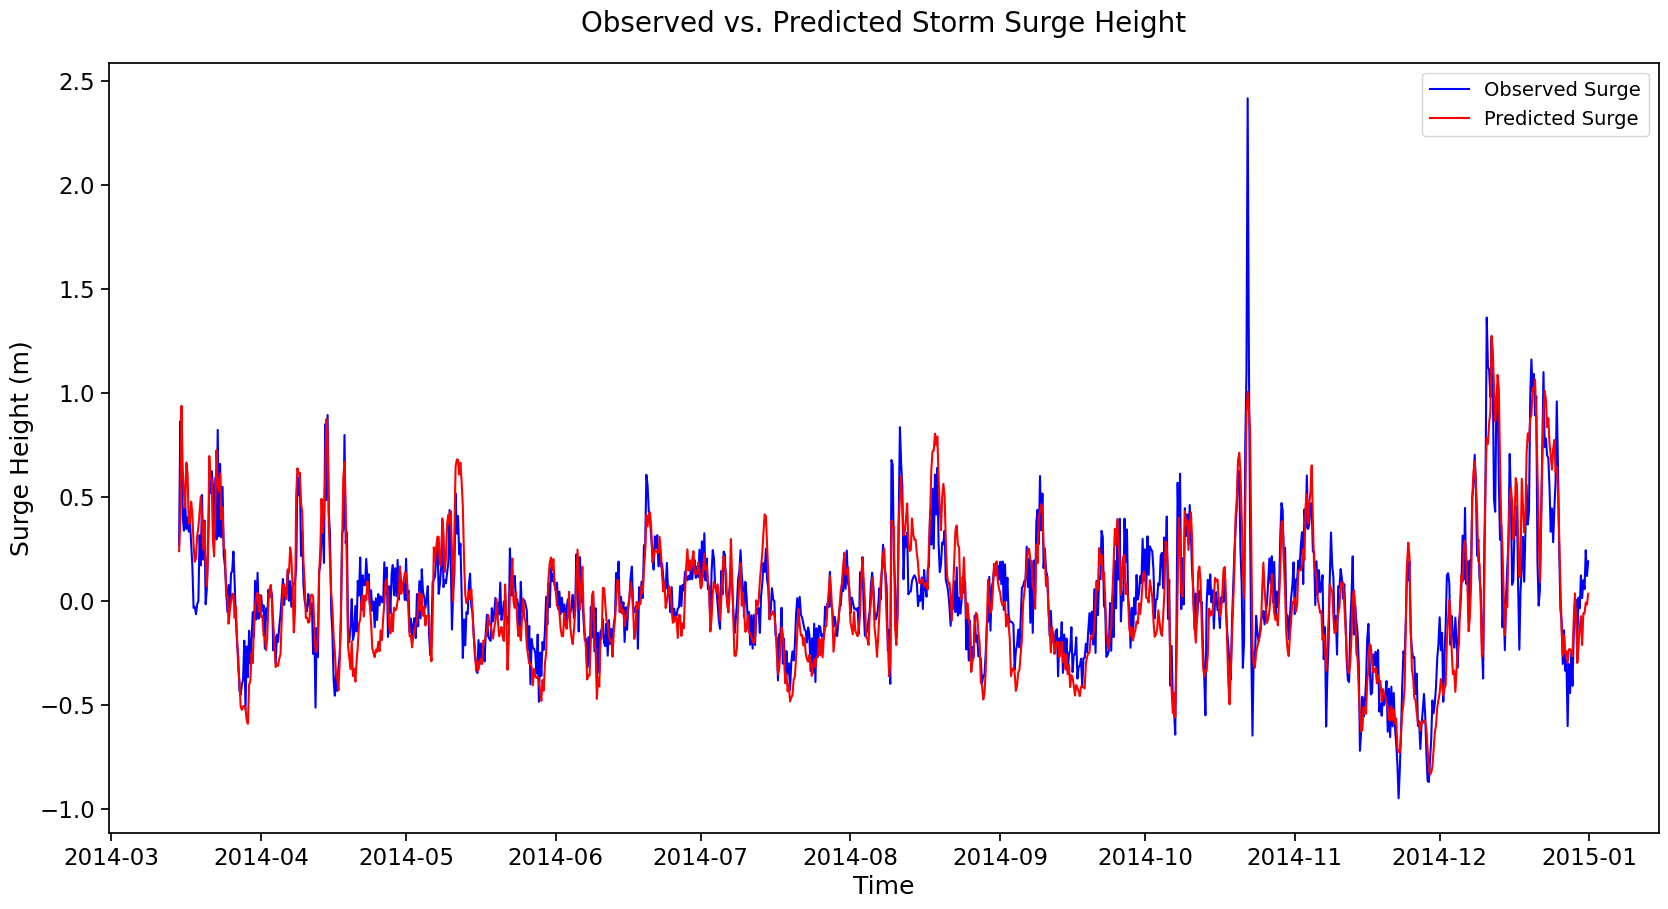

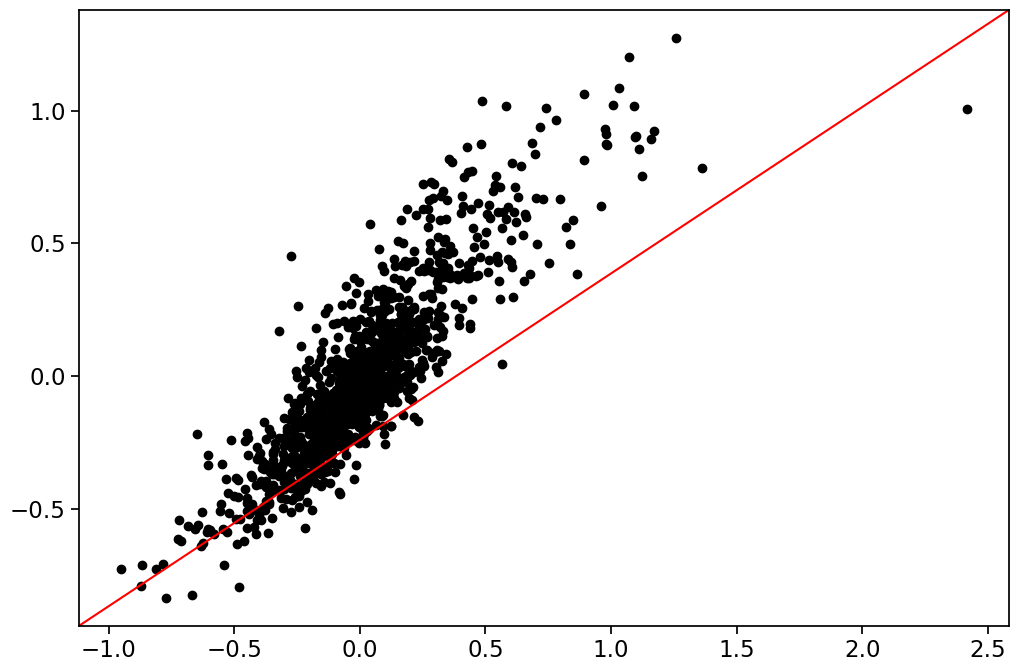

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


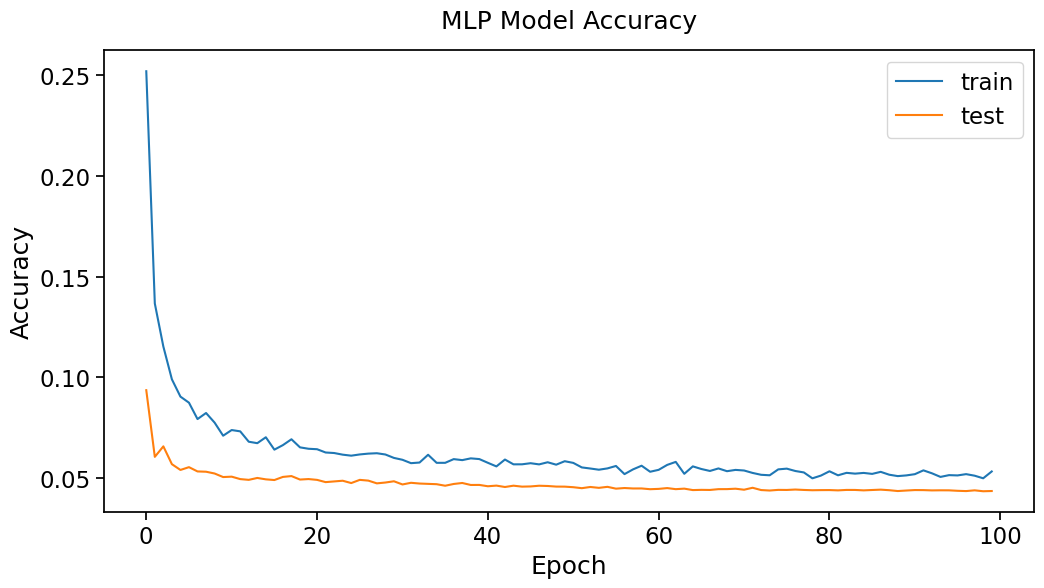

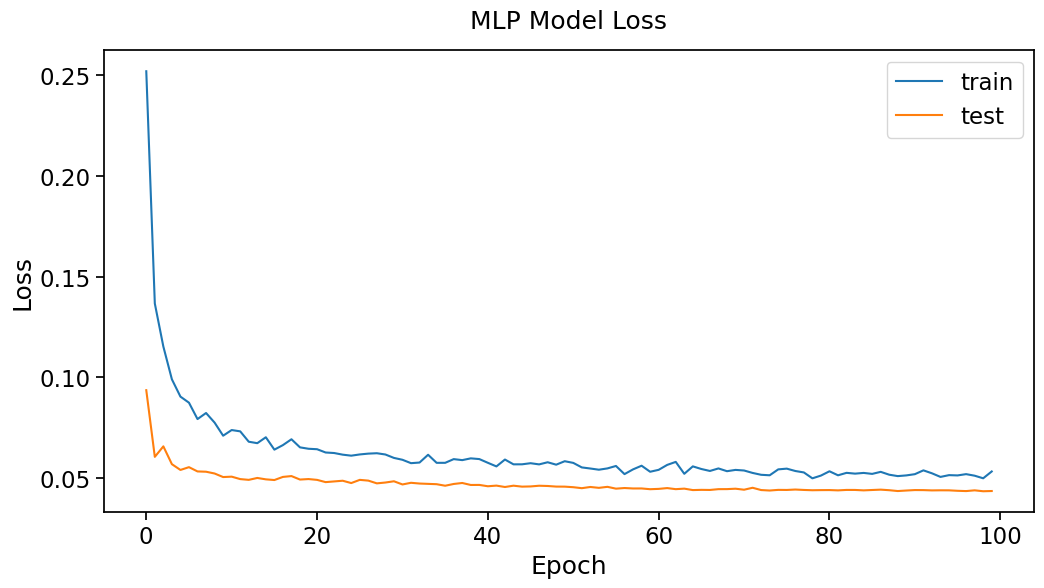

array([[ 0.23852332],
       [ 0.3821652 ],
       [ 0.9372387 ],
       ...,
       [-0.00839379],
       [-0.01850287],
       [ 0.03381375]], dtype=float32)

In [70]:
mlp_seq(x_norm_train, x_norm_test, y_train, y_test)

In [79]:
#convolution neural network
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

# Assuming x_trn has shape (num_samples, sequence_length, input_dim)
x_trn = np.array(x.copy())
x_trn = x_trn.reshape(x_trn.shape[0], x_trn.shape[1], 1)

# Model definition with adjusted input_shape
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_trn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
model.fit(x_trn, surge['surge'], epochs=1000, verbose=0)
